<a href="https://colab.research.google.com/github/DemirhanUmut/COMP2200-Masters-MQ-2022/blob/main/aaaaaaa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessed Task 3: Specification
## Basic text classification

*  Student name: Umut Demirhan
*  Student ID: 46739106
*  Unit code and name: COMP8220 Machine Learning


In this assessed task,  text classification with 7 sub-tasks is demonstrated

## Task 0 


In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [ ]:
print(tf.__version__)

2.9.2


## Sentiment analysis




### Download and explore the IMDB dataset


In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
# drive_dir = "/content/drive/MyDrive/FL/text_classify"
dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 9s 0us/step


In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsup',
 'urls_unsup.txt',
 'pos',
 'labeledBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'neg',
 'unsupBow.feat']

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training


In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

In [ ]:
train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [ ]:
embedding_dim = 16

In [ ]:
OrigNN = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

OrigNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

### Loss function and optimizer

Now, configure the model to use an optimizer and a loss function:

In [ ]:
OrigNN.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model


In [ ]:
epochs = 10
history = OrigNN.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 15s 19ms/step - loss: 0.6634 - binary_accuracy: 0.6973 - val_loss: 0.6142 - val_binary_accuracy: 0.7746
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5481 - binary_accuracy: 0.8026 - val_loss: 0.4979 - val_binary_accuracy: 0.8220
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4443 - binary_accuracy: 0.8441 - val_loss: 0.4199 - val_binary_accuracy: 0.8462
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3780 - binary_accuracy: 0.8662 - val_loss: 0.3733 - val_binary_accuracy: 0.8608
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3350 - binary_accuracy: 0.8787 - val_loss: 0.3445 - val_binary_accuracy: 0.8672
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3049 - binary_accuracy: 0.8881 - val_loss: 0.3255 - val_binary_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 3s 4ms/s

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = OrigNN.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 6s 8ms/step - loss: 0.3103 - binary_accuracy: 0.8734
Loss:  0.31028228998184204
Accuracy:  0.8734400272369385


### Create a plot of accuracy and loss over time


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

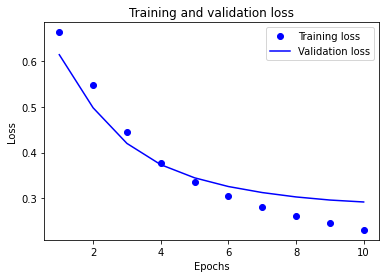

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

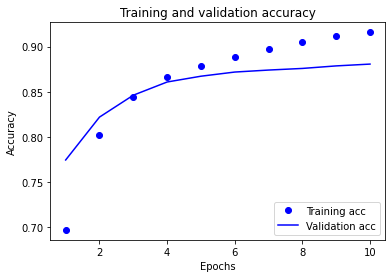

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Export the model

In [ ]:
export_OrigNN = tf.keras.Sequential([
  vectorize_layer,
  OrigNN,
  layers.Activation('sigmoid')
])

export_OrigNN.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_OrigNN.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 7s 9ms/step - loss: 0.3103 - accuracy: 0.8734
0.8734400272369385


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_OrigNN.predict(examples)

1/1 [==============================] - 0s 119ms/step


array([[0.6088988 ],
       [0.4310202 ],
       [0.34893325]], dtype=float32)

# Task 1 

In [ ]:
DenseNNi = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dense(220),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

DenseNNi.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dense_1 (Dense)             (None, None, 220)         3740      
                                                                 
 dropout_2 (Dropout)         (None, None, 220)         0         
                                                                 
 global_average_pooling1d_1   (None, 220)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 220)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 221       
                                                      

In [ ]:
DenseNNi.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
epochs = 10
history_DenseNNi = DenseNNi.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.4543 - binary_accuracy: 0.7711 - val_loss: 0.3103 - val_binary_accuracy: 0.8728
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2428 - binary_accuracy: 0.9039 - val_loss: 0.3051 - val_binary_accuracy: 0.8754
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1839 - binary_accuracy: 0.9317 - val_loss: 0.3392 - val_binary_accuracy: 0.8652
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1440 - binary_accuracy: 0.9483 - val_loss: 0.3879 - val_binary_accuracy: 0.8646
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1134 - binary_accuracy: 0.9619 - val_loss: 0.4459 - val_binary_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.0884 - binary_accuracy: 0.9718 - val_loss: 0.5221 - val_binary_accuracy: 0.8630
Epoch 7/10
625/625 [==============================] - 3s 5ms/ste

In [ ]:
loss, accuracy = DenseNNi.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 3ms/step - loss: 0.8275 - binary_accuracy: 0.8359
Loss:  0.8275288939476013
Accuracy:  0.8358799815177917


At the first epoch DenseNNi model has 0.87 accuracy while Ori model only has 0.77 but increase to the last epoch DenseNNi model accuracy is only 0.85, Ori model accuracy is 0.88 => We can see Ori model better than DenseNNi

# Task 2

In [ ]:
DenseNNii = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dense(220),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.6),
  layers.Dense(1)])

DenseNNii.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160016    
                                                                 
 dense_3 (Dense)             (None, None, 220)         3740      
                                                                 
 dropout_4 (Dropout)         (None, None, 220)         0         
                                                                 
 global_average_pooling1d_2   (None, 220)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 220)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 221       
                                                      

In [ ]:
DenseNNiii = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dense(220),
  layers.Dropout(0.6),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

DenseNNiii.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          160016    
                                                                 
 dense_5 (Dense)             (None, None, 220)         3740      
                                                                 
 dropout_6 (Dropout)         (None, None, 220)         0         
                                                                 
 global_average_pooling1d_3   (None, 220)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 220)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 221       
                                                      

In [ ]:
DenseNNiv = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dense(220),
  layers.Dropout(0.6),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.6),
  layers.Dense(1)])

DenseNNiv.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 16)          160016    
                                                                 
 dense_7 (Dense)             (None, None, 220)         3740      
                                                                 
 dropout_8 (Dropout)         (None, None, 220)         0         
                                                                 
 global_average_pooling1d_4   (None, 220)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 220)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 221       
                                                      

In [ ]:
DenseNNii.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
DenseNNiii.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
DenseNNiv.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
epochs = 10
history_DenseNNii = DenseNNii.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.4919 - binary_accuracy: 0.7459 - val_loss: 0.3145 - val_binary_accuracy: 0.8714
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2567 - binary_accuracy: 0.8981 - val_loss: 0.2959 - val_binary_accuracy: 0.8790
Epoch 3/10
625/625 [==============================] - 3s 6ms/step - loss: 0.1957 - binary_accuracy: 0.9265 - val_loss: 0.3174 - val_binary_accuracy: 0.8738
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1565 - binary_accuracy: 0.9435 - val_loss: 0.3486 - val_binary_accuracy: 0.8710
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1241 - binary_accuracy: 0.9573 - val_loss: 0.4021 - val_binary_accuracy: 0.8690
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0995 - binary_accuracy: 0.9674 - val_loss: 0.4612 - val_binary_accuracy: 0.8672
Epoch 7/10
625/625 [==============================] - 3s 5ms/ste

In [ ]:
epochs = 10
history_DenseNNiii = DenseNNiii.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.4655 - binary_accuracy: 0.7640 - val_loss: 0.3098 - val_binary_accuracy: 0.8734
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2461 - binary_accuracy: 0.9021 - val_loss: 0.3049 - val_binary_accuracy: 0.8754
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.1858 - binary_accuracy: 0.9295 - val_loss: 0.3348 - val_binary_accuracy: 0.8702
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.1459 - binary_accuracy: 0.9470 - val_loss: 0.3786 - val_binary_accuracy: 0.8662
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1162 - binary_accuracy: 0.9606 - val_loss: 0.4415 - val_binary_accuracy: 0.8626
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0926 - binary_accuracy: 0.9699 - val_loss: 0.5115 - val_binary_accuracy: 0.8590
Epoch 7/10
625/625 [==============================] - 3s 5ms/ste

In [ ]:
epochs = 10
history_DenseNNiv = DenseNNiv.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.4918 - binary_accuracy: 0.7472 - val_loss: 0.3143 - val_binary_accuracy: 0.8714
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2580 - binary_accuracy: 0.8980 - val_loss: 0.2980 - val_binary_accuracy: 0.8780
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1988 - binary_accuracy: 0.9229 - val_loss: 0.3105 - val_binary_accuracy: 0.8740
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1586 - binary_accuracy: 0.9426 - val_loss: 0.3445 - val_binary_accuracy: 0.8720
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1292 - binary_accuracy: 0.9548 - val_loss: 0.3886 - val_binary_accuracy: 0.8698
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1044 - binary_accuracy: 0.9651 - val_loss: 0.4453 - val_binary_accuracy: 0.8644
Epoch 7/10
625/625 [==============================] - 3s 5ms/ste

In [ ]:
loss, accuracy = DenseNNii.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 3ms/step - loss: 1.0363 - binary_accuracy: 0.8269
Loss:  1.036281704902649
Accuracy:  0.8269199728965759


In [ ]:
loss, accuracy = DenseNNiii.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 3ms/step - loss: 0.8746 - binary_accuracy: 0.8351
Loss:  0.8746172785758972
Accuracy:  0.8351200222969055


In [ ]:
loss, accuracy = DenseNNiv.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 3ms/step - loss: 0.8818 - binary_accuracy: 0.8334
Loss:  0.8818385004997253
Accuracy:  0.8334000110626221


At the first epoch all Dense model has 0.87 accuracy, while Ori model only has 0.77 but increase to the last epoch DenseNNi, Denseiii, Denseiv model accuracy is only 0.85, Denseii accuracy is 0.84, Ori model accuracy is 0.88 => We can see Ori model better than DenseNN model

# Task 3

In [ ]:
CNNi = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.Conv1D(8, 7, padding="valid", activation="relu", strides=3),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
  ])

CNNi.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_10 (Dropout)        (None, None, 16)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 8)           904       
                                                                 
 global_average_pooling1d_5   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                      

In [ ]:
CNNii = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.Conv1D(8, 7, padding="valid", activation="relu", strides=3),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.6),
  layers.Dense(1)
  ])

CNNii.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_12 (Dropout)        (None, None, 16)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 8)           904       
                                                                 
 global_average_pooling1d_6   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_13 (Dropout)        (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                      

In [ ]:
CNNiii = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.6),
  layers.Conv1D(8, 7, padding="valid", activation="relu", strides=3),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
  ])

CNNiii.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_14 (Dropout)        (None, None, 16)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 8)           904       
                                                                 
 global_average_pooling1d_7   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_15 (Dropout)        (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                      

In [ ]:
CNNiv = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.6),
  layers.Conv1D(8, 7, padding="valid", activation="relu", strides=3),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.6),
  layers.Dense(1)
  ])

CNNiv.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_16 (Dropout)        (None, None, 16)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, None, 8)           904       
                                                                 
 global_average_pooling1d_8   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_17 (Dropout)        (None, 8)                 0         
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                      

In [ ]:
CNNi.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
CNNii.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
CNNiii.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
CNNiv.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
epochs = 10
history_CNNi = CNNi.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 9s 5ms/step - loss: 0.5729 - binary_accuracy: 0.7089 - val_loss: 0.3899 - val_binary_accuracy: 0.8574
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3618 - binary_accuracy: 0.8517 - val_loss: 0.3134 - val_binary_accuracy: 0.8794
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2965 - binary_accuracy: 0.8819 - val_loss: 0.2885 - val_binary_accuracy: 0.8844
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2648 - binary_accuracy: 0.8962 - val_loss: 0.2807 - val_binary_accuracy: 0.8862
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2390 - binary_accuracy: 0.9068 - val_loss: 0.2779 - val_binary_accuracy: 0.8878
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2158 - binary_accuracy: 0.9168 - val_loss: 0.2772 - val_binary_accuracy: 0.8898
Epoch 7/10
625/625 [==============================] - 3s 5ms/ste

In [ ]:
epochs = 10
history_CNNii = CNNii.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.6263 - binary_accuracy: 0.6350 - val_loss: 0.4784 - val_binary_accuracy: 0.8524
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4828 - binary_accuracy: 0.7633 - val_loss: 0.3862 - val_binary_accuracy: 0.8758
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4334 - binary_accuracy: 0.8000 - val_loss: 0.3536 - val_binary_accuracy: 0.8778
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3976 - binary_accuracy: 0.8208 - val_loss: 0.3299 - val_binary_accuracy: 0.8770
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3753 - binary_accuracy: 0.8324 - val_loss: 0.3157 - val_binary_accuracy: 0.8778
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3655 - binary_accuracy: 0.8378 - val_loss: 0.3094 - val_binary_accuracy: 0.8782
Epoch 7/10
625/625 [==============================] - 3s 5ms/ste

In [ ]:
epochs = 10
history_CNNiii = CNNiii.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.6025 - binary_accuracy: 0.6748 - val_loss: 0.4219 - val_binary_accuracy: 0.8444
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3912 - binary_accuracy: 0.8375 - val_loss: 0.3298 - val_binary_accuracy: 0.8746
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3247 - binary_accuracy: 0.8654 - val_loss: 0.3008 - val_binary_accuracy: 0.8788
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2968 - binary_accuracy: 0.8831 - val_loss: 0.2898 - val_binary_accuracy: 0.8806
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2740 - binary_accuracy: 0.8917 - val_loss: 0.2811 - val_binary_accuracy: 0.8862
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2596 - binary_accuracy: 0.8951 - val_loss: 0.2785 - val_binary_accuracy: 0.8852
Epoch 7/10
625/625 [==============================] - 3s 5ms/ste

In [ ]:
epochs = 10
history_CNNiv = CNNiv.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.6493 - binary_accuracy: 0.6047 - val_loss: 0.5149 - val_binary_accuracy: 0.8400
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5092 - binary_accuracy: 0.7433 - val_loss: 0.4054 - val_binary_accuracy: 0.8718
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4589 - binary_accuracy: 0.7699 - val_loss: 0.3644 - val_binary_accuracy: 0.8822
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4267 - binary_accuracy: 0.7871 - val_loss: 0.3447 - val_binary_accuracy: 0.8834
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4052 - binary_accuracy: 0.7984 - val_loss: 0.3309 - val_binary_accuracy: 0.8806
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3962 - binary_accuracy: 0.8037 - val_loss: 0.3276 - val_binary_accuracy: 0.8800
Epoch 7/10
625/625 [==============================] - 3s 5ms/ste

In [ ]:
loss, accuracy = CNNi.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3463 - binary_accuracy: 0.8647
Loss:  0.3463098704814911
Accuracy:  0.8646799921989441


In [ ]:
loss, accuracy = CNNii.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3361 - binary_accuracy: 0.8609
Loss:  0.33607274293899536
Accuracy:  0.8609200119972229


In [ ]:
loss, accuracy = CNNiii.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3158 - binary_accuracy: 0.8695
Loss:  0.3157704770565033
Accuracy:  0.8694800138473511


In [ ]:
loss, accuracy = CNNiv.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3436 - binary_accuracy: 0.8686
Loss:  0.3436060845851898
Accuracy:  0.8686000108718872


At the first epoch all CNNi and CNNii model has 0.85 accuracy, while CNNiii and CNNiv accuracy is 0.84. At the last epoch, CNNi and CNNiii accuracy is 0.88 when accuracy of CNNii and CNNiv is only 0.87. But if we check carefully CNNiii has accuracy higher than CNNi => The best of CNN model is CNNiii

In [ ]:
DenseNN = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dense(220),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

DenseNN.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
history_DenseNN = DenseNN.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.4536 - binary_accuracy: 0.7726 - val_loss: 0.3090 - val_binary_accuracy: 0.8734
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2430 - binary_accuracy: 0.9046 - val_loss: 0.3047 - val_binary_accuracy: 0.8748
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1845 - binary_accuracy: 0.9311 - val_loss: 0.3341 - val_binary_accuracy: 0.8670
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1435 - binary_accuracy: 0.9488 - val_loss: 0.3844 - val_binary_accuracy: 0.8644
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1118 - binary_accuracy: 0.9624 - val_loss: 0.4474 - val_binary_accuracy: 0.8662
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0877 - binary_accuracy: 0.9721 - val_loss: 0.5318 - val_binary_accuracy: 0.8650
Epoch 7/10
625/625 [==============================] - 3s 5ms/ste

In [ ]:
CNN = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.6),
  layers.Conv1D(8, 7, padding="valid", activation="relu", strides=3),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
  ])

CNN.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))


epochs = 10
history_CNN = CNN.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.6079 - binary_accuracy: 0.6672 - val_loss: 0.4346 - val_binary_accuracy: 0.8400
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4054 - binary_accuracy: 0.8268 - val_loss: 0.3411 - val_binary_accuracy: 0.8702
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3401 - binary_accuracy: 0.8593 - val_loss: 0.3068 - val_binary_accuracy: 0.8818
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3083 - binary_accuracy: 0.8744 - val_loss: 0.2928 - val_binary_accuracy: 0.8834
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2878 - binary_accuracy: 0.8832 - val_loss: 0.2852 - val_binary_accuracy: 0.8852
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2665 - binary_accuracy: 0.8917 - val_loss: 0.2792 - val_binary_accuracy: 0.8838
Epoch 7/10
625/625 [==============================] - 3s 5ms/ste

In [ ]:
loss, accuracy = OrigNN.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3101 - binary_accuracy: 0.8735
Loss:  0.310106486082077
Accuracy:  0.873520016670227


In [ ]:
loss, accuracy = DenseNN.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 3ms/step - loss: 0.8471 - binary_accuracy: 0.8346
Loss:  0.8471241593360901
Accuracy:  0.8346400260925293


In [ ]:
loss, accuracy = CNN.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3192 - binary_accuracy: 0.8668
Loss:  0.31918179988861084
Accuracy:  0.8667600154876709


# Task 4

In [ ]:
NNBest = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

In [ ]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.84, 
    subset='training',
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)


raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 4000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
NNBest.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
history_NNBest_20 = NNBest.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
125/125 [==============================] - 6s 32ms/step - loss: 0.6906 - binary_accuracy: 0.5487 - val_loss: 0.6869 - val_binary_accuracy: 0.7136
Epoch 2/10
125/125 [==============================] - 1s 6ms/step - loss: 0.6803 - binary_accuracy: 0.7042 - val_loss: 0.6755 - val_binary_accuracy: 0.7460
Epoch 3/10
125/125 [==============================] - 1s 6ms/step - loss: 0.6626 - binary_accuracy: 0.7632 - val_loss: 0.6575 - val_binary_accuracy: 0.7586
Epoch 4/10
125/125 [==============================] - 1s 9ms/step - loss: 0.6377 - binary_accuracy: 0.7870 - val_loss: 0.6348 - val_binary_accuracy: 0.7634
Epoch 5/10
125/125 [==============================] - 2s 12ms/step - loss: 0.6077 - binary_accuracy: 0.8012 - val_loss: 0.6098 - val_binary_accuracy: 0.7806
Epoch 6/10
125/125 [==============================] - 1s 9ms/step - loss: 0.5747 - binary_accuracy: 0.8202 - val_loss: 0.5842 - val_binary_accuracy: 0.7882
Epoch 7/10
125/125 [==============================] - 1s 10ms/

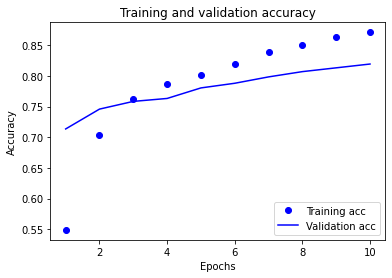

In [ ]:
history_dict = history_NNBest_20.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.68, 
    subset='training',
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)


raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 8000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
NNBest.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
history_NNBest_40 = NNBest.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
250/250 [==============================] - 5s 17ms/step - loss: 0.6523 - binary_accuracy: 0.6245 - val_loss: 0.6311 - val_binary_accuracy: 0.6690
Epoch 2/10
250/250 [==============================] - 2s 7ms/step - loss: 0.6052 - binary_accuracy: 0.6989 - val_loss: 0.5915 - val_binary_accuracy: 0.7108
Epoch 3/10
250/250 [==============================] - 2s 6ms/step - loss: 0.5581 - binary_accuracy: 0.7451 - val_loss: 0.5535 - val_binary_accuracy: 0.7444
Epoch 4/10
250/250 [==============================] - 2s 8ms/step - loss: 0.5155 - binary_accuracy: 0.7795 - val_loss: 0.5194 - val_binary_accuracy: 0.7678
Epoch 5/10
250/250 [==============================] - 2s 7ms/step - loss: 0.4753 - binary_accuracy: 0.8062 - val_loss: 0.4890 - val_binary_accuracy: 0.7868
Epoch 6/10
250/250 [==============================] - 2s 8ms/step - loss: 0.4381 - binary_accuracy: 0.8273 - val_loss: 0.4630 - val_binary_accuracy: 0.7984
Epoch 7/10
250/250 [==============================] - 2s 8ms/st

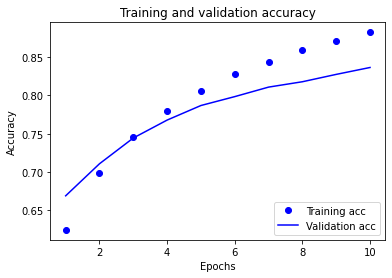

In [ ]:
history_dict = history_NNBest_40.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.52, 
    subset='training',
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)


raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 12000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
NNBest.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
history_NNBest_60 = NNBest.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
375/375 [==============================] - 7s 16ms/step - loss: 0.6433 - binary_accuracy: 0.6491 - val_loss: 0.6018 - val_binary_accuracy: 0.6840
Epoch 2/10
375/375 [==============================] - 2s 4ms/step - loss: 0.5645 - binary_accuracy: 0.7122 - val_loss: 0.5479 - val_binary_accuracy: 0.7254
Epoch 3/10
375/375 [==============================] - 2s 5ms/step - loss: 0.5089 - binary_accuracy: 0.7587 - val_loss: 0.5065 - val_binary_accuracy: 0.7584
Epoch 4/10
375/375 [==============================] - 2s 6ms/step - loss: 0.4642 - binary_accuracy: 0.7922 - val_loss: 0.4730 - val_binary_accuracy: 0.7838
Epoch 5/10
375/375 [==============================] - 2s 6ms/step - loss: 0.4244 - binary_accuracy: 0.8192 - val_loss: 0.4461 - val_binary_accuracy: 0.7980
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 0.3925 - binary_accuracy: 0.8363 - val_loss: 0.4230 - val_binary_accuracy: 0.8096
Epoch 7/10
375/375 [==============================] - 3s 8ms/st

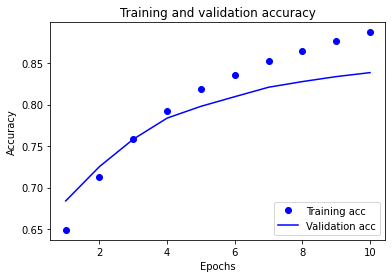

In [ ]:
history_dict = history_NNBest_60.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.36, 
    subset='training',
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)


raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 16000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
NNBest.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
history_NNBest_80 = NNBest.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
500/500 [==============================] - 9s 17ms/step - loss: 0.7323 - binary_accuracy: 0.6197 - val_loss: 0.6538 - val_binary_accuracy: 0.6698
Epoch 2/10
500/500 [==============================] - 2s 4ms/step - loss: 0.5920 - binary_accuracy: 0.7031 - val_loss: 0.5657 - val_binary_accuracy: 0.7234
Epoch 3/10
500/500 [==============================] - 2s 4ms/step - loss: 0.5108 - binary_accuracy: 0.7546 - val_loss: 0.5084 - val_binary_accuracy: 0.7554
Epoch 4/10
500/500 [==============================] - 2s 4ms/step - loss: 0.4532 - binary_accuracy: 0.7933 - val_loss: 0.4679 - val_binary_accuracy: 0.7822
Epoch 5/10
500/500 [==============================] - 2s 4ms/step - loss: 0.4118 - binary_accuracy: 0.8210 - val_loss: 0.4363 - val_binary_accuracy: 0.8002
Epoch 6/10
500/500 [==============================] - 2s 4ms/step - loss: 0.3751 - binary_accuracy: 0.8419 - val_loss: 0.4114 - val_binary_accuracy: 0.8186
Epoch 7/10
500/500 [==============================] - 3s 5ms/st

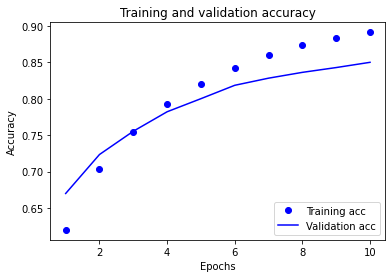

In [ ]:
history_dict = history_NNBest_80.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training',
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)


raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
NNBest.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
history_NNBest_100 = NNBest.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 8s 13ms/step - loss: 0.6437 - binary_accuracy: 0.6811 - val_loss: 0.5874 - val_binary_accuracy: 0.7120
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5257 - binary_accuracy: 0.7492 - val_loss: 0.5136 - val_binary_accuracy: 0.7540
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4590 - binary_accuracy: 0.7916 - val_loss: 0.4667 - val_binary_accuracy: 0.7788
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4122 - binary_accuracy: 0.8207 - val_loss: 0.4332 - val_binary_accuracy: 0.8014
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3778 - binary_accuracy: 0.8418 - val_loss: 0.4080 - val_binary_accuracy: 0.8130
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3485 - binary_accuracy: 0.8571 - val_loss: 0.3882 - val_binary_accuracy: 0.8276
Epoch 7/10
625/625 [==============================] - 3s 4ms/st

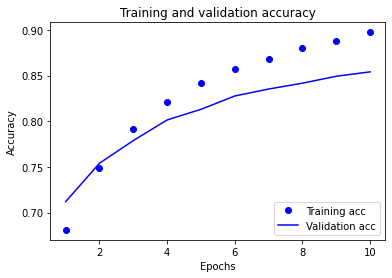

In [ ]:
history_dict = history_NNBest_100.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Task 5

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.9.0"

     |████████████████████████████████| 4.6 MB 34.6 MB/s 


In [ ]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 18.7 MB/s 
     |████████████████████████████████| 352 kB 60.5 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 238 kB 60.6 MB/s 
     |████████████████████████████████| 99 kB 9.5 MB/s 
     |████████████████████████████████| 1.1 MB 53.9 MB/s 
     |████████████████████████████████| 1.3 MB 46.8 MB/s 
     |████████████████████████████████| 118 kB 77.5 MB/s 


In [ ]:
import numpy as np

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds_bert = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 


tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
def build_classifier_model(dropout_value):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(dropout_value)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
BERTi = build_classifier_model(dropout_value=0.1)
BERTii = build_classifier_model(dropout_value=0.2)
BERTiii = build_classifier_model(dropout_value=0.6)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
from official.nlp import optimization

epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERTi.compile(optimizer=optimizer, loss=loss, metrics=metrics)
BERTii.compile(optimizer=optimizer, loss=loss, metrics=metrics)
BERTiii.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history_BERTi = BERTi.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 162s 253ms/step - loss: 0.1652 - binary_accuracy: 0.9127 - val_loss: 0.4904 - val_binary_accuracy: 0.8428
Epoch 2/10
625/625 [==============================] - 157s 251ms/step - loss: 0.1645 - binary_accuracy: 0.9389 - val_loss: 0.5580 - val_binary_accuracy: 0.8488
Epoch 3/10
625/625 [==============================] - 157s 251ms/step - loss: 0.1156 - binary_accuracy: 0.9604 - val_loss: 0.6975 - val_binary_accuracy: 0.8414
Epoch 4/10
625/625 [==============================] - 157s 251ms/step - loss: 0.0892 - binary_accuracy: 0.9711 - val_loss: 0.7577 - val_binary_accuracy: 0.8468
Epoch 5/10
625/625 [==============================] - 157s 251ms/step - loss: 0.0681 - binary_accuracy: 0.9800 - val_loss: 0.8085 - val_binary_accuracy: 0.8476
Epoch 6/10
625/625 [==============================] - 157s 251ms/step - loss: 0.0549 - binary_accuracy: 0.9840 - val_loss: 0.8688 - val_binary_accuracy: 0.8504
Epoch 7/10
625/625 [====================

In [ ]:
history_BERTii = BERTii.fit(x=train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 160s 252ms/step - loss: 0.4115 - binary_accuracy: 0.7973 - val_loss: 0.4222 - val_binary_accuracy: 0.7748
Epoch 2/10
625/625 [==============================] - 156s 250ms/step - loss: 0.4094 - binary_accuracy: 0.7861 - val_loss: 0.4222 - val_binary_accuracy: 0.7748
Epoch 3/10
625/625 [==============================] - 157s 251ms/step - loss: 0.4095 - binary_accuracy: 0.7852 - val_loss: 0.4222 - val_binary_accuracy: 0.7748
Epoch 4/10
625/625 [==============================] - 157s 252ms/step - loss: 0.4070 - binary_accuracy: 0.7844 - val_loss: 0.4222 - val_binary_accuracy: 0.7748
Epoch 5/10
625/625 [==============================] - 156s 250ms/step - loss: 0.4086 - binary_accuracy: 0.7844 - val_loss: 0.4222 - val_binary_accuracy: 0.7748
Epoch 6/10
625/625 [==============================] - 157s 251ms/step - loss: 0.4096 - binary_accuracy: 0.7845 - val_loss: 0.4222 - val_binary_accuracy: 0.7748
Epoch 7/10
625/625 [====================

In [ ]:
history_BERTiii = BERTii.fit(x=train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 158s 252ms/step - loss: 0.4088 - binary_accuracy: 0.7850 - val_loss: 0.4222 - val_binary_accuracy: 0.7748
Epoch 2/10
625/625 [==============================] - 157s 251ms/step - loss: 0.4086 - binary_accuracy: 0.7833 - val_loss: 0.4222 - val_binary_accuracy: 0.7748
Epoch 3/10
625/625 [==============================] - 157s 251ms/step - loss: 0.4106 - binary_accuracy: 0.7826 - val_loss: 0.4222 - val_binary_accuracy: 0.7748
Epoch 4/10
625/625 [==============================] - 156s 250ms/step - loss: 0.4060 - binary_accuracy: 0.7837 - val_loss: 0.4222 - val_binary_accuracy: 0.7748
Epoch 5/10
625/625 [==============================] - 157s 252ms/step - loss: 0.4095 - binary_accuracy: 0.7849 - val_loss: 0.4222 - val_binary_accuracy: 0.7748
Epoch 6/10
625/625 [==============================] - 157s 252ms/step - loss: 0.4094 - binary_accuracy: 0.7827 - val_loss: 0.4222 - val_binary_accuracy: 0.7748
Epoch 7/10
625/625 [====================

In [ ]:
loss, accuracy = BERTi.evaluate(test_ds_bert)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 87s 111ms/step - loss: 0.9837 - binary_accuracy: 0.8538
Loss: 0.9836998581886292
Accuracy: 0.8537600040435791


In [ ]:
loss, accuracy = BERTii.evaluate(test_ds_bert)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 107s 137ms/step - loss: 0.4125 - binary_accuracy: 0.7808
Loss: 0.4125295579433441
Accuracy: 0.7807599902153015


In [ ]:
loss, accuracy = BERTiii.evaluate(test_ds_bert)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 86s 109ms/step - loss: 0.7996 - binary_accuracy: 0.6383
Loss: 0.7996100783348083
Accuracy: 0.6383399963378906


Model Berti's accuracy is about 0.85 but both Bertii and Bertiii accuracy are 0.77. So that Berti is best model.


NNBest accuracy start from 0.77 to 0.85 but Berti model has 0.85 as the first epoch, so that Berti better than NNBest model

# Task 6

In [1]:
data_test_bert = [[example.numpy(), label.numpy()] for example, label in test_ds_bert]

NameError: ignored

In [ ]:
data_test_data = np.concatenate(np.array(data_test_bert)[:, 0])
data_test_label = np.concatenate(np.array(data_test_bert)[:, 1])

In [ ]:
~pos_data_test = []
neg_data_test = []
for data, label in zip(data_test_data, data_test_label):
  if label==0:
    pos_data_test.append(data)
  else:
    neg_data_test.append(data)

In [ ]:
export_NNBest = tf.keras.Sequential([
  vectorize_layer,
  NNBest,
  layers.Activation('sigmoid')
])

export_NNBest.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

In [ ]:
y_probas = np.stack([export_NNBest.predict(pos_data_test[:5], verbose=0) for sample in range(10)])
y_proba_pos_NNBestDrop = y_probas.mean(axis=0)

y_probas = np.stack([export_NNBest.predict(neg_data_test[:5], verbose=0) for sample in range(10)])
y_proba_neg_NNBestDrop = y_probas.mean(axis=0)

In [ ]:
y_probas_pos_NNBest = export_NNBest.predict(pos_data_test[:5], verbose=0)
y_probas_neg_NNBest = export_NNBest.predict(neg_data_test[:5], verbose=0)

#### Comparison

In [ ]:
y_probas_pos_NNBest

array([[0.2562559 ],
       [0.05173336],
       [0.35413727],
       [0.00589286],
       [0.02678989]], dtype=float32)

In [ ]:
y_proba_pos_NNBestDrop

array([[0.2562559 ],
       [0.05173337],
       [0.35413724],
       [0.00589286],
       [0.02678989]], dtype=float32)

*Don*'t have different between NNBestDrop and NNBest on positive prediction

In [ ]:
y_probas_neg_NNBest

array([[0.17842512],
       [0.5899117 ],
       [0.8549421 ],
       [0.18661907],
       [0.6854551 ]], dtype=float32)

In [ ]:
y_proba_neg_NNBestDrop

array([[0.1784251 ],
       [0.58991164],
       [0.8549422 ],
       [0.18661906],
       [0.68545514]], dtype=float32)

=> models predict wrong neg[0] ad neg[1]

In [ ]:
neg_data_test[0]

b"In defense of this movie I must repeat what I had stated previously. The movie is called Arachina, it has a no name cast and I do not mean no name as in actors who play in little seen art house films. I mean no name as in your local high school decided to make a film no name and it might have a 2 dollar budget. So what does one expect? Hitchcock?<br /><br />I felt the movie never took itself seriously which automatically takes it out of the worst movie list. That list is only for big budget all star cast movies that takes itself way too seriously. THe movie The Oscar comes to mind, most of Sylvester Stallone's movies. THe two leads were not Hepburn and Tracy but they did their jobs well enough for this movie. The woman kicked butt and the guy was not a blithering idiot. The actor who played the old man was actually very good. The man who played anal retentive professor was no Clifton Webb but he did a god job. And the Bimbo's for lack of a better were played by two competent actors. 

In [ ]:
neg_data_test[3]

b"The first thing you see in this film is a static angle(one which will be repeated later in the film), depicting the chaos going on(unseen to the audience) in a studio that airs news. Soon after, Fonda's character's typical story is shown, in that same angle. Don't let this mislead you; the film is not about a female reporter, a woman struggling to succeed in a male-dominated profession. That is merely a lead-in, a way of starting the film(though it's used later). The actual point to this production is revealed gradually, and the first we see of it is in a deliberately long scene early on. The entire film has that pace; not slow or drawn-out, but deliberate. It's never really fast, even in the few sequences that one would normally expect to be so. This pacing(especially because it seems to slow down further as the plot is revealed, as the disturbing, unsettling nature of the film is unraveled) is strong, almost painful to the viewer. It inspires you to, if it had been possible, jump i

# Task 7

In [ ]:
y_probas_pos_NNBest = export_NNBest.predict(pos_data_test, verbose=0)
y_probas_neg_NNBest = export_NNBest.predict(neg_data_test, verbose=0)

In [ ]:
y_probas_pos_NNBest_correctly, most_pos_data_test_correctly = zip(*sorted(zip(y_probas_pos_NNBest, pos_data_test))[:20])
y_probas_neg_NNBest_correctly, most_neg_data_test_correctly = zip(*sorted(zip(y_probas_neg_NNBest, neg_data_test), reverse=True)[:20])

In [ ]:
y_probas = np.stack([export_NNBest.predict(most_pos_data_test_correctly, verbose=0) for sample in range(10)])
y_proba_pos_NNBestDrop_correctly = y_probas.mean(axis=0)

y_probas = np.stack([export_NNBest.predict(most_neg_data_test_correctly, verbose=0) for sample in range(10)])
y_proba_neg_NNBestDrop_correctly = y_probas.mean(axis=0)

In [ ]:
y_probas_pos_NNBest_correctly

(array([2.7302275e-07], dtype=float32),
 array([3.080672e-07], dtype=float32),
 array([7.3397007e-07], dtype=float32),
 array([7.451666e-07], dtype=float32),
 array([1.0765368e-06], dtype=float32),
 array([1.9850931e-06], dtype=float32),
 array([1.989416e-06], dtype=float32),
 array([2.6292525e-06], dtype=float32),
 array([3.3440294e-06], dtype=float32),
 array([4.090032e-06], dtype=float32),
 array([4.2580605e-06], dtype=float32),
 array([4.377012e-06], dtype=float32),
 array([4.435678e-06], dtype=float32),
 array([4.435678e-06], dtype=float32),
 array([5.020089e-06], dtype=float32),
 array([5.297503e-06], dtype=float32),
 array([5.4641987e-06], dtype=float32),
 array([6.190604e-06], dtype=float32),
 array([6.3539483e-06], dtype=float32),
 array([6.656453e-06], dtype=float32))

Don't have different between NNBestDrop and NNBest on top 20 most positive prediction

In [2]:
y_proba_pos_NNBestDrop_correctly

NameError: ignored

In [ ]:
y_proba_pos_NNBestDrop_correctly

array([[0.9997958 ],
       [0.99912345],
       [0.9989213 ],
       [0.99865973],
       [0.9983355 ],
       [0.9977597 ],
       [0.9976822 ],
       [0.99719465],
       [0.99697316],
       [0.99653757],
       [0.99630773],
       [0.996276  ],
       [0.99542344],
       [0.9953597 ],
       [0.9947589 ],
       [0.99463624],
       [0.9944171 ],
       [0.9943546 ],
       [0.9942821 ],
       [0.99360526]], dtype=float32)

In [ ]:
y_proba_neg_NNBestDrop_correctly

array([[0.9999999 ],
       [0.999998  ],
       [0.9999975 ],
       [0.9999896 ],
       [0.9999887 ],
       [0.99997747],
       [0.99997556],
       [0.99997294],
       [0.9999696 ],
       [0.9999598 ],
       [0.99994576],
       [0.9999403 ],
       [0.9999355 ],
       [0.99993527],
       [0.99993503],
       [0.99992573],
       [0.99991715],
       [0.99991596],
       [0.999899  ],
       [0.9998989 ]], dtype=float32)

Model NNBestDrop accurate than NNBest

#### Repeat the above, but for the 20 most positive and 20 most negative reviews under the best model NNBest that are incorrectly classified.


In [ ]:
y_probas_pos_NNBest_incorrectly, most_pos_data_test_incorrectly = zip(*sorted(zip(y_probas_pos_NNBest, pos_data_test), reverse=True)[:20])
y_probas_neg_NNBest_incorrectly, most_neg_data_test_incorrectly = zip(*sorted(zip(y_probas_neg_NNBest, neg_data_test))[:20])

In [ ]:
y_probas = np.stack([export_NNBest.predict(most_pos_data_test_incorrectly, verbose=0) for sample in range(10)])
y_proba_pos_NNBestDrop_incorrectly = y_probas.mean(axis=0)

y_probas = np.stack([export_NNBest.predict(most_neg_data_test_incorrectly, verbose=0) for sample in range(10)])
y_proba_neg_NNBestDrop_incorrectly = y_probas.mean(axis=0)

In [ ]:
most_pos_data_test_incorrectly[0]

b'Based on the comments made so far, everyone seems to either hate this movie or love it. I think it would be fair to point out that although this is not a GREAT movie, it has its interesting moments. For one thing, it was filmed on location in Colorado (was it Breckinridge or Telluride? I can\'t remember, but it is in the credits). The location is absolutely stunning and spectacular. It\'s beautiful, even to me who lived in Colorado for several years.<br /><br />Next, it has Disney\'s penchant for wonderful character actors. Harry Morgan has never been in better form than when he plays in a Disney movie. He is literally hysterical. Also, remember the wonderful Mary Wickes? Although she has a "bit part" in this movie, she is great, as always. If you don\'t know who she is, think of the animated Disney version of Hunchback from Notre Dame (she was one of the gargoyles), and she was also the most interesting nun in "Sister Act", as well as the best nun in "The Trouble With Angels." She h

In [ ]:
most_neg_data_test_incorrectly[0]

b"This is one of Bruce's most underrated films in my opinion, its an awesome heartwarming film, with a neat story and an amazing performance from Bruce Willis!. All the characters are great, and I thought Willis and Spencer Breslin were just awesome together, plus Bruce Willis is simply amazing in this!. This is definitely one of Bruce's best comedic performances (The waaaaaaaaaamabulance thing was great) and I thought it was very well written and made as well, plus The finale is especially cool!. It's good natured and it was cool how you can see Russell's (Willis) character change throughout the film! plus the ending was pretty good. I think this should be higher then 6.0 and it's one of the best Disney films I have ever seen! plus it has many surprising moments throughout. All the characters are extremely likable, and it also has a cute love story angle too it as well, plus Bruce and Spencer Breslin both had some really funny lines (Holy Smokes!). This is one of Bruce's most underrat

In [ ]:
y_probas_pos_NNBest_incorrectly

(array([0.99979585], dtype=float32),
 array([0.9991235], dtype=float32),
 array([0.9989213], dtype=float32),
 array([0.99865973], dtype=float32),
 array([0.9983354], dtype=float32),
 array([0.9977596], dtype=float32),
 array([0.9976821], dtype=float32),
 array([0.99719465], dtype=float32),
 array([0.99697316], dtype=float32),
 array([0.99653757], dtype=float32),
 array([0.99630785], dtype=float32),
 array([0.996276], dtype=float32),
 array([0.9954235], dtype=float32),
 array([0.9953597], dtype=float32),
 array([0.9947589], dtype=float32),
 array([0.99463624], dtype=float32),
 array([0.99441695], dtype=float32),
 array([0.9943547], dtype=float32),
 array([0.99428225], dtype=float32),
 array([0.9936052], dtype=float32))

In [ ]:
y_probas_neg_NNBest_incorrectly

(array([0.99999976], dtype=float32),
 array([0.999998], dtype=float32),
 array([0.9999975], dtype=float32),
 array([0.9999896], dtype=float32),
 array([0.9999888], dtype=float32),
 array([0.9999776], dtype=float32),
 array([0.9999757], dtype=float32),
 array([0.99997294], dtype=float32),
 array([0.9999697], dtype=float32),
 array([0.9999598], dtype=float32),
 array([0.9999459], dtype=float32),
 array([0.9999403], dtype=float32),
 array([0.9999355], dtype=float32),
 array([0.9999354], dtype=float32),
 array([0.9999349], dtype=float32),
 array([0.99992573], dtype=float32),
 array([0.99991715], dtype=float32),
 array([0.99991596], dtype=float32),
 array([0.99989915], dtype=float32),
 array([0.9998989], dtype=float32))

In [ ]:
y_probas_neg_NNBest_incorrectly

(array([0.00021638], dtype=float32),
 array([0.0003066], dtype=float32),
 array([0.0003066], dtype=float32),
 array([0.00068529], dtype=float32),
 array([0.000728], dtype=float32),
 array([0.00079302], dtype=float32),
 array([0.00191887], dtype=float32),
 array([0.00223991], dtype=float32),
 array([0.00236068], dtype=float32),
 array([0.00255201], dtype=float32),
 array([0.00263213], dtype=float32),
 array([0.00286532], dtype=float32),
 array([0.00291019], dtype=float32),
 array([0.00303425], dtype=float32),
 array([0.00361979], dtype=float32),
 array([0.0040234], dtype=float32),
 array([0.00422195], dtype=float32),
 array([0.00432992], dtype=float32),
 array([0.00432992], dtype=float32),
 array([0.00447718], dtype=float32))

In [ ]:
y_proba_neg_NNBestDrop_incorrectly

array([[0.00021638],
       [0.0003066 ],
       [0.0003066 ],
       [0.00068529],
       [0.000728  ],
       [0.00079302],
       [0.00191887],
       [0.00223991],
       [0.00236068],
       [0.00255201],
       [0.00263213],
       [0.00286532],
       [0.00291019],
       [0.00303425],
       [0.00361979],
       [0.0040234 ],
       [0.00422195],
       [0.00432992],
       [0.00432992],
       [0.00447718]], dtype=float32)

Both models don't have much different between wrong prediction on positive and negative